# Early Lung Cancer Prediction using Machine Learning

## Objective
To build an early lung cancer prediction system using patient symptoms and lifestyle data,
compare multiple machine learning models, and explain the predictions using SHAP.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_curve, roc_auc_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost as xgb


/opt/anaconda3/envs/lung_cancer_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv("../data/survey lung cancer.csv")
df.columns = df.columns.str.strip()   # remove extra spaces
df.head()


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [4]:
print("Shape:", df.shape)
df.info()


Shape: (309, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_C

In [5]:
df["LUNG_CANCER"].value_counts()


LUNG_CANCER
YES    270
NO      39
Name: count, dtype: int64

In [6]:
# Reload dataset fresh (important)
df = pd.read_csv("../data/survey lung cancer.csv")
df.columns = df.columns.str.strip()

# Encode target FIRST
df["LUNG_CANCER"] = df["LUNG_CANCER"].map({"YES": 1, "NO": 0})

# Encode gender
df["GENDER"] = df["GENDER"].map({"M": 1, "F": 0})

# Convert remaining 1/2 columns to 0/1 (exclude target)
feature_cols = df.columns.drop("LUNG_CANCER")
df[feature_cols] = df[feature_cols].replace({1: 0, 2: 1})

# 🔴 DROP any rows with NaN (very few, safe)
df = df.dropna().reset_index(drop=True)

# FINAL CHECK
print("NaNs in target:", df["LUNG_CANCER"].isna().sum())
df.head()


NaNs in target: 0


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,0,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,0,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,0,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


In [7]:
print(df["LUNG_CANCER"].value_counts())


LUNG_CANCER
1    270
0     39
Name: count, dtype: int64


In [8]:
X = df.drop("LUNG_CANCER", axis=1)
y = df["LUNG_CANCER"]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True),
    "MLP": MLPClassifier(max_iter=1000),
    "XGBoost": xgb.XGBClassifier(eval_metric="logloss")
}


In [12]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.919355,0.945455,0.962963,0.954128,0.949074
1,KNN,0.887097,0.927273,0.944444,0.935780,0.899306
2,Naive Bayes,0.887097,0.927273,0.944444,0.935780,0.918981
3,Decision Tree,0.903226,0.980000,0.907407,0.942308,0.891204
4,Random Forest,0.919355,0.962264,0.944444,0.953271,0.956019
5,SVM,0.870968,0.910714,0.944444,0.927273,0.928241
6,MLP,0.887097,0.960784,0.907407,0.933333,0.935185
7,XGBoost,0.870968,0.925926,0.925926,0.925926,0.925926


In [13]:
best_model_name = results_df.sort_values("ROC AUC", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]

print("Best Model:", best_model_name)


Best Model: Random Forest


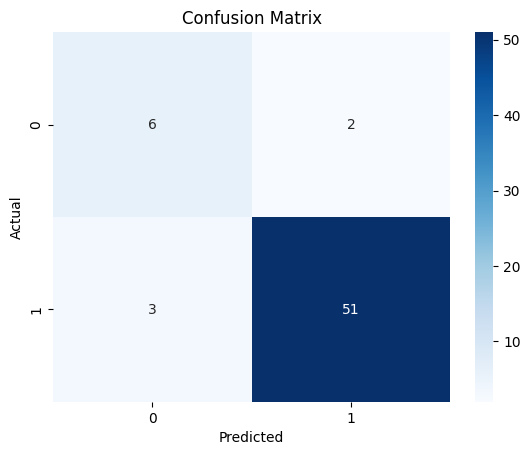

In [14]:
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


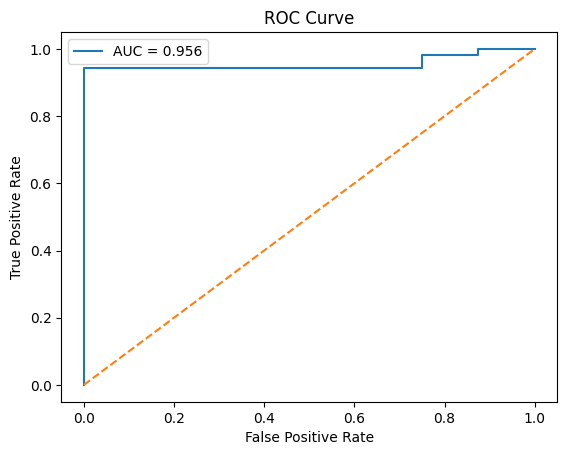

In [15]:
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig("../reports/roc_curve.png")
plt.show()


In [16]:
joblib.dump(best_model, "../artifacts/best_model.joblib")
joblib.dump(scaler, "../artifacts/scaler.joblib")


['../artifacts/scaler.joblib']

SHAP shape: (247, 15, 2)
X shape: (247, 15)


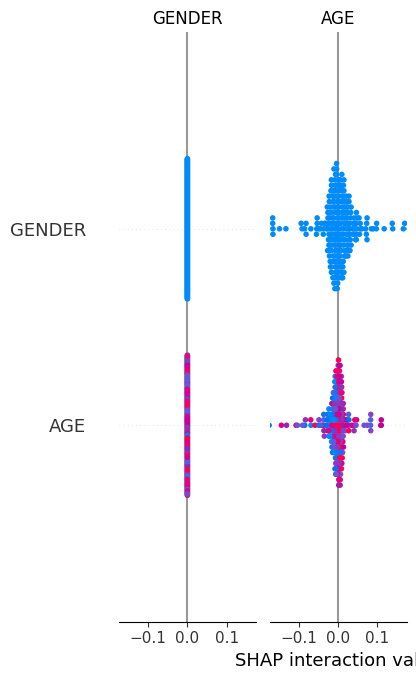

In [17]:
# ---------- SHAP EXPLAINABILITY (STABLE VERSION) ----------

# Use UN-SCALED training data for interpretability
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# TreeExplainer is the correct explainer for XGBoost
explainer = shap.TreeExplainer(best_model)

# Get SHAP values
shap_values = explainer.shap_values(X_train_df)

# For binary classification, shap_values can be:
# - a list [class0, class1]
# - or a single array
if isinstance(shap_values, list):
    shap_vals_pos = shap_values[1]   # class 1 = lung cancer
else:
    shap_vals_pos = shap_values

# If SHAP adds an extra bias column, remove it
if shap_vals_pos.shape[1] != X_train_df.shape[1]:
    shap_vals_pos = shap_vals_pos[:, :-1]

# Final sanity check
print("SHAP shape:", shap_vals_pos.shape)
print("X shape:", X_train_df.shape)

# Summary plot
shap.summary_plot(shap_vals_pos, X_train_df, show=False)
plt.savefig("../reports/shap_summary.png")
plt.show()


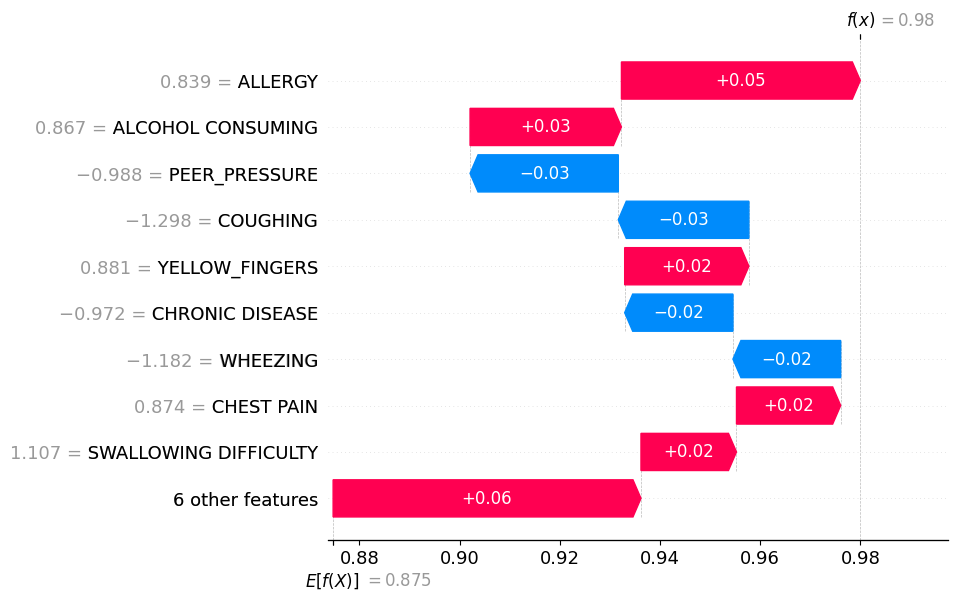

In [20]:
# ---------- SHAP WATERFALL (FINAL FIX) ----------

# Select FIRST patient
patient_index = 0

# Extract SHAP values correctly for POSITIVE class (class = 1)
# Handles shape: (samples, features, classes)
if shap_vals_pos.ndim == 3:
    shap_values_patient = shap_vals_pos[patient_index, :, 1]
else:
    shap_values_patient = shap_vals_pos[patient_index]

# Get correct base value for positive class
if isinstance(explainer.expected_value, (list, np.ndarray)):
    base_value = explainer.expected_value[1]
else:
    base_value = explainer.expected_value

# Build explanation
exp = shap.Explanation(
    values=shap_values_patient,
    base_values=base_value,
    data=X_train_df.iloc[patient_index],
    feature_names=X_train_df.columns
)

# Plot waterfall
shap.plots.waterfall(exp, show=False)
plt.savefig("../reports/shap_waterfall.png")
plt.show()
